In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from transformers import pipeline
from tqdm import tqdm

In [2]:
main_df = pd.read_csv('./data/main_data.csv')
main_df.shape

(19250, 11)

In [3]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19250 entries, 0 to 19249
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   True              19250 non-null  int64 
 1   index             19250 non-null  int64 
 2   subreddit         19250 non-null  int64 
 3   num_comments      19250 non-null  int64 
 4   created_utc       19250 non-null  int64 
 5   author            19250 non-null  object
 6   title_word_count  19250 non-null  int64 
 7   title_length      19250 non-null  int64 
 8   post              19250 non-null  object
 9   post_stemmed      19250 non-null  object
 10  post_unstemmed    19250 non-null  object
dtypes: int64(7), object(4)
memory usage: 1.6+ MB


In [4]:
X = main_df['post_stemmed']
y = main_df['subreddit']
y.value_counts(normalize=True)

# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [5]:
tvec = TfidfVectorizer(min_df=3)

# Fit X_train and X_test to tfid transformer and then concat both data into a single data frame
X_train_tvec = pd.DataFrame(
    tvec.fit_transform(X_train).todense(),
    columns = tvec.get_feature_names()
)
print(f'Train data shape: {X_train_tvec.shape}')

X_test_tvec = pd.DataFrame(
    tvec.transform(X_test).todense(),
    columns = tvec.get_feature_names()
)
print(f'Train data shape: {X_test_tvec.shape}')

# combined_X_tvec = pd.concat([X_train_tvec, X_test_tvec])
# print(f'Combined Train/Test data shape: {combined_X_tvec.shape}')
# # Split the data back to train and test data with missing features from train/test
# X_train_tvec = combined_X_tvec[0:len(X_train)]
# X_test_tvec = combined_X_tvec[len(X_train):]
# X_train_tvec = X_train_tvec.fillna(0)
# X_test_tvec = X_test_tvec.fillna(0)

Train data shape: (15400, 6339)
Train data shape: (3850, 6339)


# Modeling

## GridSearch & Pipeline

In [12]:
def gridsearch(estimator,params,cv,x_train,y_train,x_test,y_test):
    gs = GridSearchCV(estimator, # What is the model we want to fit?
                                params, # What is the dictionary of hyperparameters?
                                cv=cv, # What number of folds in CV will we use?
                                verbose=1,
                                n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                                )

    gs.fit(x_train,y_train)
    print(f'Best training score: {gs.best_score_}')
    print(f'Best parameter: {gs.best_params_}')
    print(f'Test Score: {gs.score(x_test, y_test)}')
    y_pred = gs.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, columns=['pred DC_Cinematic', 'pred marvelstudio'], index=['actual DC_Cinematic', 'actual marvelstudio'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.show();
    return gs, y_pred


                             

In [13]:
# Parameter initialization
logr_params = {
    'penalty':['l1','l2'],
    'C' : [1,0.1,0.01],
    'solver': ['liblinear']
}

knn_params = {
    'n_neighbors': [5], #range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}





## Logistic Regression Model

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best training score: 0.920085931470498
Best parameter: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test Score: 0.9227568270481145


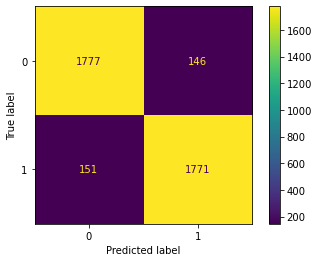

In [11]:
# logr = LogisticRegression(penalty = 'l1', C = 1,solver ='liblinear',random_state=42)

# logr_model = logr.fit(X_train_tvec, y_train)

# y_pred_logr = logr_model.predict(X_test_tvec)

# print(f'Train data accuracy score: {logr.score(X_train_tvec, y_train)}')
# print(f'Test data accuracy score: {logr.score(X_test_tvec, y_test)}')

logr = LogisticRegression()
logr_gs, y_pred_logr = gridsearch(logr,logr_params,5,X_train_tvec,y_train,X_test_tvec,y_test)

Interpreting Logistic Regression Coefficient

The logistic regression coefficient β associated with a predictor X is the expected change in log odds of having the outcome per unit change in X. So increasing the predictor by 1 unit (or going from 1 level to the next) multiplies the odds of having the outcome by expo(β).

<AxesSubplot:title={'center':'Most Important Feature (Marvel)'}, xlabel='logr_coefficient', ylabel='feature'>

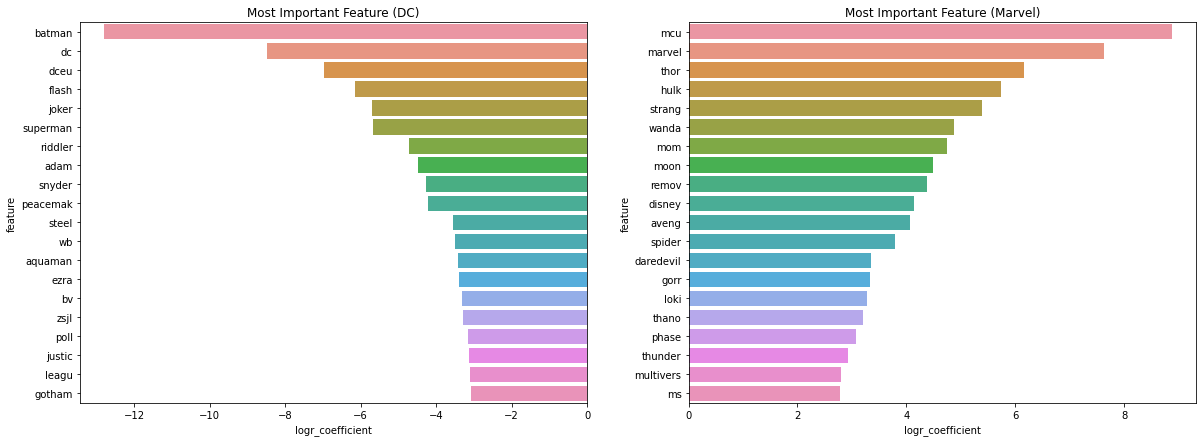

In [83]:
logr_top_features = pd.DataFrame(X_train_tvec.columns,columns=['feature'])
logr_top_features['logr_coefficient'] = pd.DataFrame(logr_gs.best_estimator_.coef_[0])
marvel_logr_top_feature = logr_top_features.sort_values('logr_coefficient',ascending=False).head(20)
dc_logr_top_feature = logr_top_features.sort_values('logr_coefficient',ascending=True).head(20)

fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].title.set_text('Most Important Feature (DC)')
axs[1].title.set_text('Most Important Feature (Marvel)')
# axs[0].yaxis.tick_right()
sns.barplot(data = dc_logr_top_feature, x = 'logr_coefficient',y='feature',ax = axs[0])
sns.barplot(data = marvel_logr_top_feature, x = 'logr_coefficient',y='feature',ax = axs[1])

## K-Nearest Neighbor Model

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 35.1min finished


Best training score: 0.6329407000962076
Best parameter: {'metric': 'euclidean', 'n_neighbors': 5}
Test Score: 0.6504551365409623


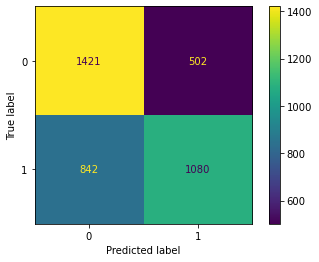

In [38]:
# knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')

# knn_model = knn.fit(X_train_tvec,y_train)

# y_pred_knn = knn_model.predict(X_test_tvec)

# print(f'Train data accuracy score: {knn_model.score(X_train_tvec, y_train)}')
# print(f'Test data accuracy score: {knn_model.score(X_test_tvec, y_test)}')

# knn = KNeighborsClassifier()

# knn_gs, y_pred_knn = gridsearch(knn,knn_params,5,X_train_tvec,y_train,X_test_tvec,y_test)

## Multinominal Naive Bayes Model

In [9]:
nb = MultinomialNB()
# Fit our model!
nb_model = nb.fit(X_train_tvec, y_train)
# Generate our predictions!
y_pred_nb = nb_model.predict(X_test_tvec)

# Score our model on the training set.
print(f'Train data accuracy score: {nb_model.score(X_train_tvec, y_train)}')

# Score our model on the training set.
print(f'Test data accuracy score: {nb_model.score(X_test_tvec, y_test)}')

Train data accuracy score: 0.9396579751609337
Test data accuracy score: 0.9115734720416124


Interpreting Multinomial Naive Bayes Model Coefficient

With reference to notes found in the following link: https://donernesto.github.io/blog/notes-on-multinomial-naive-bayes/

<AxesSubplot:title={'center':'Most Important Feature (Marvel)'}, xlabel='delta_log_prob', ylabel='feature'>

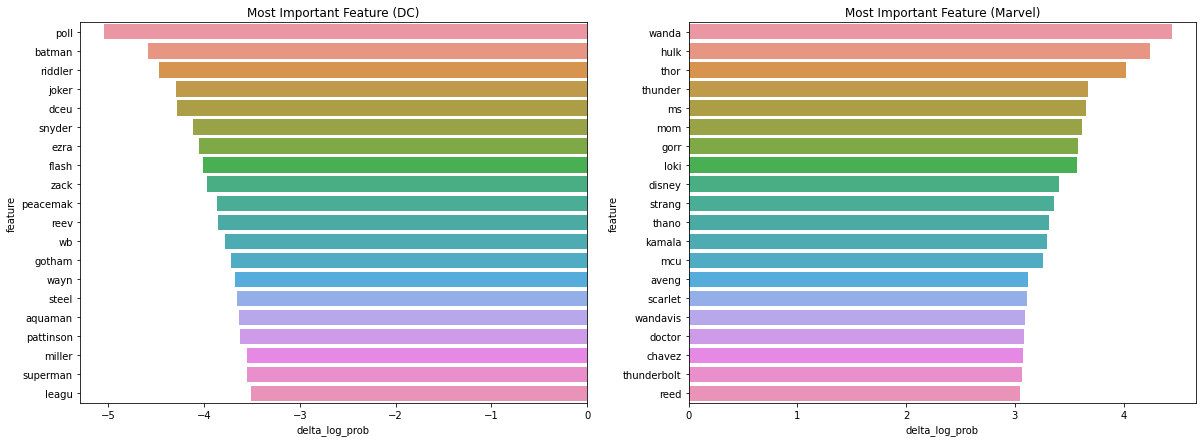

In [57]:
# log probability of features for class 0
nb.feature_log_prob_[0,:]

# log probability of features for class 1
nb.feature_log_prob_[1,:]

# By getting the delta of probability for each individual features, we are able to identify the features that are most important to each classes
# Positive value means it is important for class 1 and negative value is for class 0
delta_log_prob = nb.feature_log_prob_[1,:] - nb.feature_log_prob_[0,:]

# New dataframe to match the delta log prob with the features
top_features = pd.DataFrame(X_train_tvec.columns,columns=['feature'])
top_features['delta_log_prob'] = pd.DataFrame(delta_log_prob)
marvel_top_feature = top_features.sort_values('delta_log_prob',ascending=False).head(20)
dc_top_feature = top_features.sort_values('delta_log_prob',ascending=True).head(20)

fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].title.set_text('Most Important Feature (DC)')
axs[1].title.set_text('Most Important Feature (Marvel)')
sns.barplot(data = dc_top_feature, x = 'delta_log_prob',y='feature',ax = axs[0])
sns.barplot(data = marvel_top_feature, x = 'delta_log_prob',y='feature',ax = axs[1])

## Random Forest Classification Model

In [12]:
rf = RandomForestClassifier() # The number of decision trees in the forest is 100 by default so does not need to be explicitly specified

rf_params = {
    'n_estimators': [100, 150, 200], # iterating over different number of trees in the forest
    'max_depth': [None, 1, 2, 3], # iterating over a defined set of max depth of tree. For None, the nodes are expanded until all leaves are pure
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_tvec, y_train)
print(gs.best_score_)
gs.best_params_

0.9110474378085783


{'max_depth': None, 'n_estimators': 200}

## Hugging Face

In [14]:
# classifier = pipeline("zero-shot-classification",
#                       model="facebook/bart-large-mnli")

classifier = pipeline("sentiment-analysis",
                      model="finiteautomata/bertweet-base-sentiment-analysis")

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji


In [15]:
# df = main_df.sample(10)
sequence_to_classify = list(main_df['post_unstemmed'])
candidate_labels = ['dc','marvel']
sentiment_result = classifier(sequence_to_classify,truncation = True)
sentiment_df = pd.DataFrame(sentiment_result)
sentiment_df['post_unstemmed'] =  main_df['post_unstemmed'].reset_index(drop=True)
sentiment_df

,label,score,post_unstemmed
0,POS,0.924385,agree marvel movies two make top
1,NEU,0.938668,captain america fan film fight scene
2,NEU,0.969352,guy phd dr strange thought
3,POS,0.648603,top marvel movies agree
4,NEU,0.943673,spider man lotus controversy
...,...,...,...
19245,NEU,0.822718,apparently cyborg batfleck supposed camo peace...
19246,NEU,0.940822,watch theatrical justice league snyder cut rew...
19247,NEU,0.943281,since dwayne confident black adam fight superm...
19248,NEG,0.969725,sad batfleck cyborg robbed


In [16]:
main_df['sentiment'] = sentiment_df['label']
main_df['sentiment_score'] = sentiment_df['score']
main_df

,True,index,subreddit,num_comments,created_utc,author,title_word_count,title_length,post,post_stemmed,post_unstemmed,sentiment,sentiment_score
0,0,0,1,0,1655815616,AlknA24,15,68,Can we agree that out of all the marvel movies...,agre marvel movi two make top,agree marvel movies two make top,POS,0.924385
1,1,1,1,0,1655815581,SteveHarrington2025,6,36,Captain America Fan Film Fight Scene,captain america fan film fight scene,captain america fan film fight scene,NEU,0.938668
2,2,2,1,0,1655814965,Jack-mclaughlin89,13,61,"For a guy with a PHD, Dr Strange should have t...",guy phd dr strang thought,guy phd dr strange thought,NEU,0.969352
3,3,3,1,0,1655814697,AlknA24,9,38,My top 5 Marvel movies (5-1) - Agree ?,top marvel movi agre,top marvel movies agree,POS,0.648603
4,4,4,1,0,1655814645,Neil-patil,5,38,More on Spider-Man Lotus’ controversy.,spider man lotu controversi,spider man lotus controversy,NEU,0.943673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19245,19309,19985,0,2,1645293583,KeenBean1997,13,78,"So, apparently Cyborg and Batfleck were suppos...",appar cyborg batfleck suppos camo peacemak,apparently cyborg batfleck supposed camo peace...,NEU,0.822718
19246,19310,19986,0,51,1645293472,Prestigious_Bonus322,11,63,Should I watch the theatrical justice league o...,watch theatric justic leagu snyder cut rewatch...,watch theatrical justice league snyder cut rew...,NEU,0.940822
19247,19311,19987,0,15,1645293170,697ox,14,84,Since Dwayne is confident that black Adam will...,sinc dwayn confid black adam fight superman co...,since dwayne confident black adam fight superm...,NEU,0.943281
19248,19312,19988,0,553,1645292628,acetrainer03,9,50,This is just sad. Batfleck and Cyborg were rob...,sad batfleck cyborg rob,sad batfleck cyborg robbed,NEG,0.969725


<AxesSubplot:title={'center':'Sentiment Score (Marvel)'}, xlabel='sentiment', ylabel='Count'>

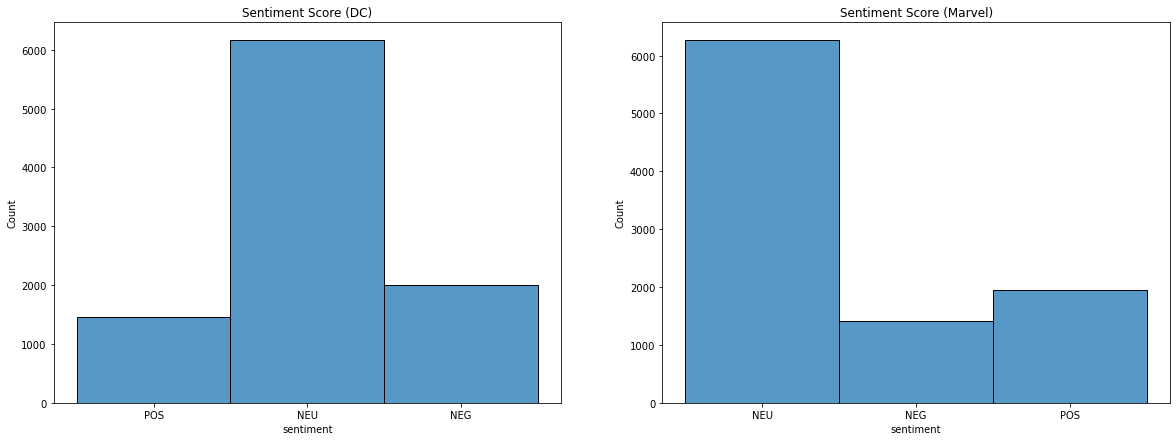

In [17]:
marvel_sentiment = main_df.loc[main_df['subreddit']==0,:]
dc_sentiment = main_df.loc[main_df['subreddit']==1,:]
fig, axs = plt.subplots(1, 2, figsize=(20,7))
axs[0].title.set_text('Sentiment Score (DC)')
axs[1].title.set_text('Sentiment Score (Marvel)')
sns.histplot(data = dc_sentiment, x = 'sentiment',ax = axs[0])
sns.histplot(data = marvel_sentiment, x = 'sentiment',ax = axs[1])

In [18]:
pd.DataFrame.to_csv(main_df,'./data/sentiment_result.csv',index_label=True)